# Pre trained model weights

### model :1 Model_weights_DRIVE.h5


### Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense,
    Activation, Add, Multiply, Permute, Concatenate, Conv2D, Lambda
)
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, precision_recall_curve
import warnings
import time
warnings.filterwarnings("ignore")

###  CUSTOM METRICS & LOSS FUNCTIONS 

In [3]:
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

def iou(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def dice_coef(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

def sensitivity(y_train, results):
    true_positives = K.sum(K.round(K.clip(y_train * results, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def DiceLoss(y_true, y_pred, smooth=1e-6):
    y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
    nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
    denominator = tf.reduce_sum(y_pred ** 2) + tf.reduce_sum(y_true ** 2) + smooth
    result = 1 - tf.divide(nominator, denominator)
    return result

def bcc_Jaccard_coef_loss(y_true, y_pred):
    return DiceLoss(y_true, y_pred, smooth=1e-6) + (1 - iou(y_true, y_pred, threshold=0.5))

# ==================== CBAM ATTENTION MODULE ====================
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio, activation='relu', 
                             kernel_initializer='he_normal', use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1,
                         padding='same', activation='sigmoid',
                         kernel_initializer='he_normal', use_bias=False)(concat)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])


###  MODEL ARCHITECTURE 

In [4]:
def create_transfuse_net(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder - Convolutional Blocks
    conv_block1 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_block1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block1)
    conv_block1 = layers.BatchNormalization()(conv_block1)

    conv_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(conv_block1)
    conv_block2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block2)
    conv_block2 = layers.BatchNormalization()(conv_block2)

    conv_block3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv_block2)
    conv_block3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block3)
    conv_block3 = layers.BatchNormalization()(conv_block3)

    # Encoder - Transformer Block
    transformer_block = layers.Reshape((-1, conv_block3.shape[3]))(conv_block3)
    transformer_block = layers.MultiHeadAttention(num_heads=4, key_dim=16)(transformer_block, transformer_block)
    transformer_block = layers.GlobalAveragePooling1D()(transformer_block)
    transformer_block = layers.Reshape((1, 1, transformer_block.shape[1]))(transformer_block)
    transformer_block = layers.Lambda(lambda x: tf.tile(x, [1, conv_block3.shape[1], conv_block3.shape[2], 1]))(transformer_block)

    # Fusion with CBAM
    att1 = cbam_block(transformer_block)
    fused_features = layers.Concatenate()([conv_block3, att1])

    # Decoder - Upsampling Blocks
    decoder_block1 = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(fused_features)
    att2 = cbam_block(decoder_block1)
    decoder_block1 = layers.Concatenate()([att2, conv_block2])
    decoder_block1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block1)

    decoder_block2 = layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block1)
    att3 = cbam_block(decoder_block2)
    decoder_block2 = layers.Concatenate()([att3, conv_block1])
    decoder_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block2)

    decoder_block3 = layers.Conv2DTranspose(8, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block2)
    decoder_block3 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block3)
    
    # Decoder - Output Block
    output_BV = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name='final_output1')(decoder_block3)
    output_OD = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name='final_output2')(decoder_block3)

    model = models.Model(inputs=inputs, outputs=[output_BV, output_OD])
    return model


### DATA LOADING FUNCTION

In [5]:
def get_data(path, im_height=512, im_width=512):
    images_path = os.path.join(path, 'images')
    masks_path_BV = os.path.join(path, 'mask')  # DRIVE test uses 'mask' folder
    
    # Get sorted image files
    images_ids = sorted([f for f in os.listdir(images_path) if f.endswith(('.tif', '.png', '.jpg'))])
    
    n_images = len(images_ids)
    X = np.zeros((n_images, im_height, im_width, 3), dtype=np.float32)
    y = np.zeros((n_images, im_height, im_width, 1), dtype=np.float32)
    
    print(f'Loading {n_images} images from {path}...')
    for n in range(n_images):
        img_name = images_ids[n]
        
        # Load images
        img = img_to_array(load_img(os.path.join(images_path, img_name), color_mode='rgb'))
        x_img = resize(img, (im_height, im_width, 3), mode='constant', preserve_range=True)
        
        # Load corresponding mask (e.g., 01_test.tif -> 01_test_mask.gif)
        mask_name = img_name.replace('.tif', '_mask.gif').replace('.png', '_mask.gif').replace('.jpg', '_mask.gif')
        mask_path = os.path.join(masks_path_BV, mask_name)
        
        if os.path.exists(mask_path):
            mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
            mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
        else:
            print(f"Warning: Mask not found for {img_name}, using zeros")
            mask = np.zeros((im_height, im_width, 1), dtype=np.float32)
        
        # Normalize
        X[n] = x_img / 255.0
        y[n] = mask / 255.0
    
    print('Done!')
    return X, y


### EVALUATION METRICS 

In [6]:
def evaluate_metrics(y_test, y_pred):
    n = y_pred.shape[0]
    all_F1_score = np.zeros(n)
    all_dice = np.zeros(n)
    all_jaccard = np.zeros(n)
    all_sensitivity = np.zeros(n)
    all_specificity = np.zeros(n)
    
    for i in range(n):
        gt, pred = y_test[i], y_pred[i]
        gt_flt = np.ndarray.flatten(gt)
        pred_flt = np.ndarray.flatten(pred)
        
        precisions, recalls, thresholds = precision_recall_curve(gt_flt, pred_flt)
        f1 = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        max_value = np.argmax(f1)
        thres = thresholds[max_value] if max_value < len(thresholds) else 0.5
        pred_label = (pred_flt >= thres).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(gt_flt, pred_label).ravel()
        
        all_F1_score[i] = tp / (tp + 0.5 * (fp + fn) + 1e-10)
        all_jaccard[i] = tp / (tp + fp + fn + 1e-10)
        all_dice[i] = 2 * tp / (2 * tp + fp + fn + 1e-10)
        all_specificity[i] = tn / (tn + fp + 1e-10)
        all_sensitivity[i] = tp / (tp + fn + 1e-10)
    
    print(f'\nF1_score: {np.nanmean(all_F1_score):.4f}, Dice: {np.nanmean(all_dice):.4f}, '
          f'Jaccard: {np.nanmean(all_jaccard):.4f}, Sensitivity: {np.nanmean(all_sensitivity):.4f}, '
          f'Specificity: {np.nanmean(all_specificity):.4f}')
    
    return all_F1_score, all_dice, all_jaccard, all_sensitivity, all_specificity



### MAIN EXECUTION

Creating model...


I0000 00:00:1763660058.419297      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763660058.419979      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Loading weights from: /kaggle/input/pretrained/keras/default/1/MTLTransfuseep300bs16head4.h5
Weights loaded successfully!

Loading test data from: /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test
Loading 20 images from /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test...
Done!

Running inference...


I0000 00:00:1763660063.748808     122 service.cc:148] XLA service 0x783898412510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763660063.749601     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763660063.749620     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763660063.977861     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763660075.200438     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Total Inference Time: 13.07 seconds
Inference Time per image: 0.6536 seconds

=== Blood Vessel Segmentation Metrics ===

F1_score: 0.9890, Dice: 0.9890, Jaccard: 0.9783, Sensitivity: 0.9949, Specificity: 0.9627

Predictions saved as 'predictions.png'


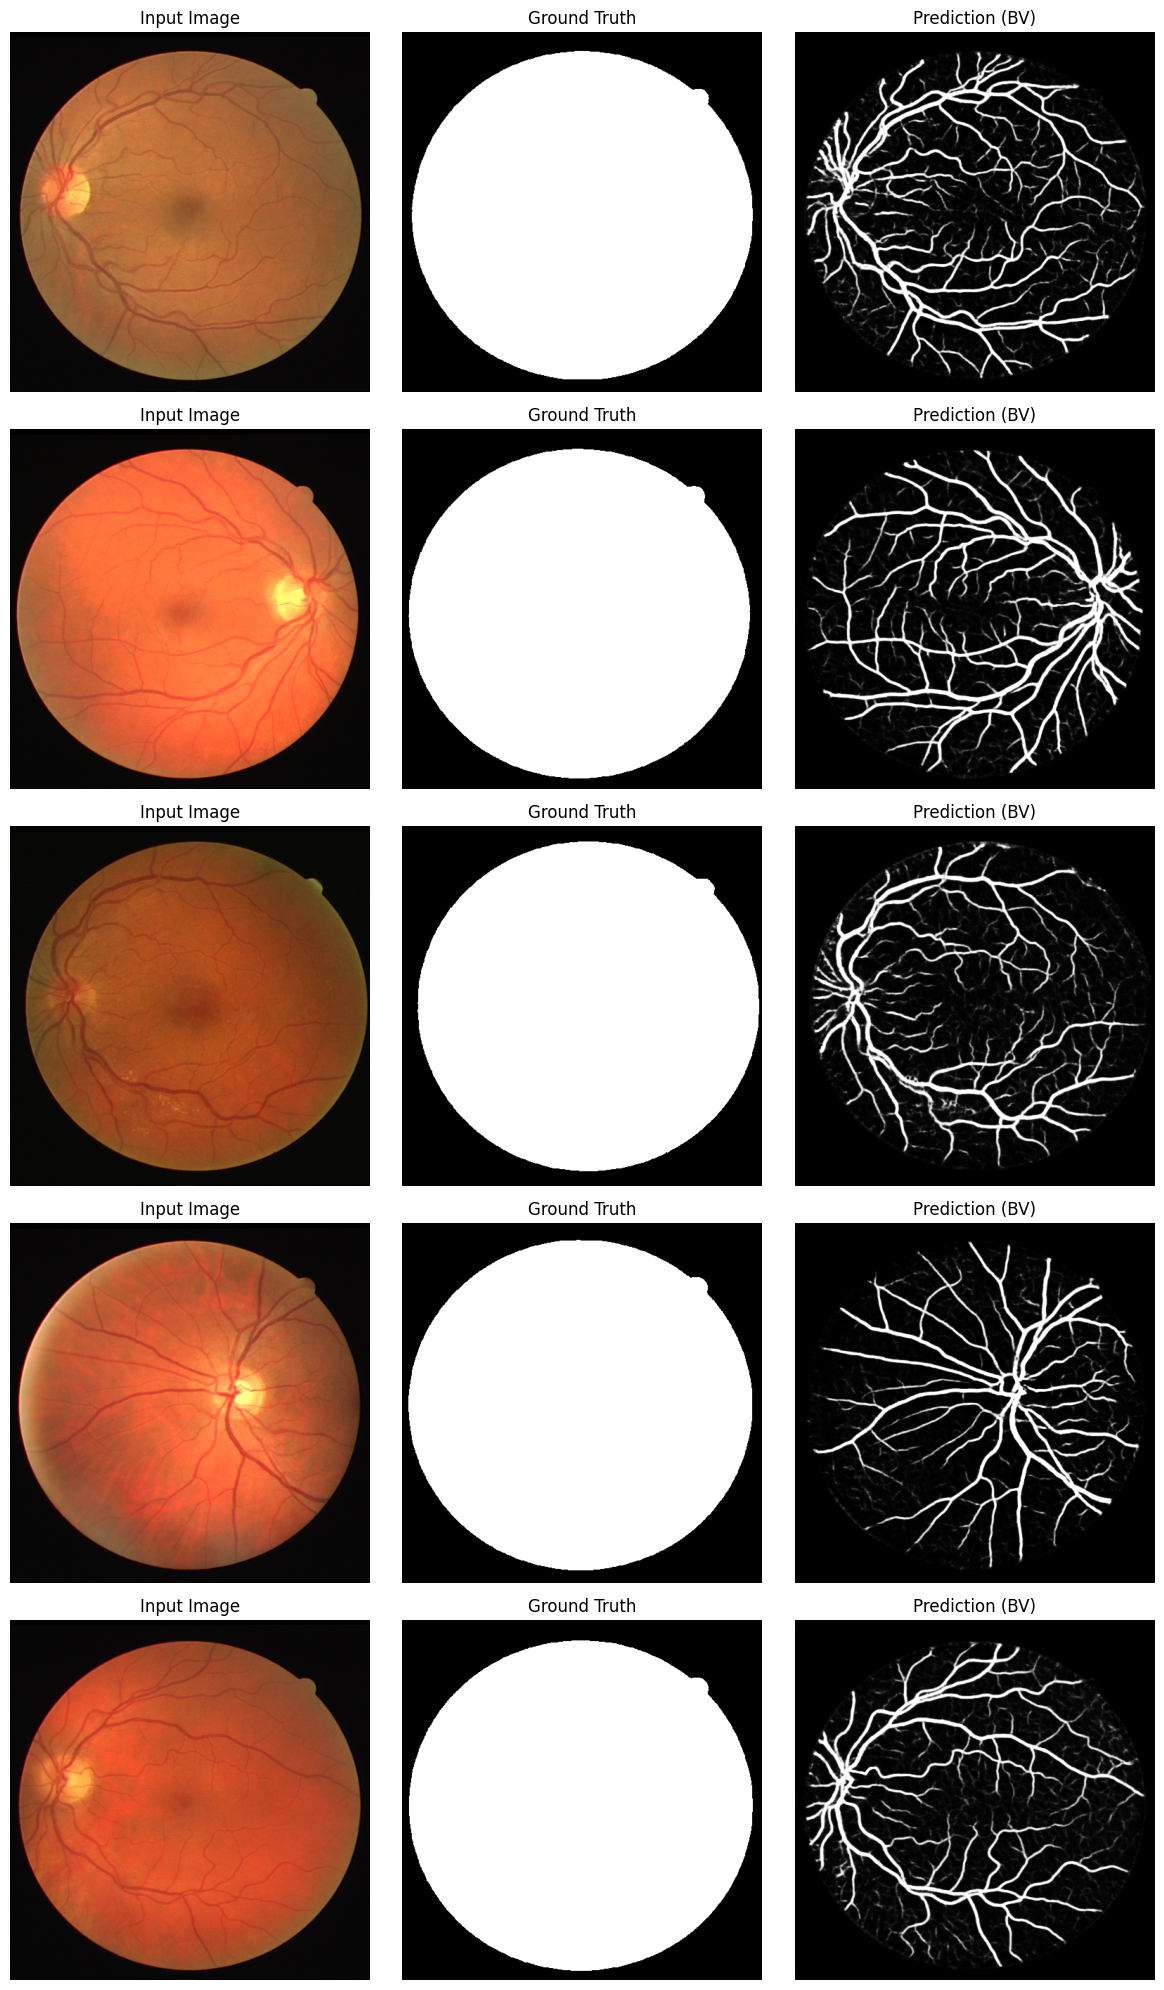


=== Evaluation Complete ===


In [7]:

if __name__ == "__main__":
    # Paths
    weights_path = '/kaggle/input/pretrained/keras/default/1/Model_weights_DRIVE.h5'
    test_data_path = '/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test'
    
    # Create model
    input_shape = (512, 512, 3)
    print("Creating model...")
    model = create_transfuse_net(input_shape)
    
    # Compile model with custom metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss={'final_output1': bcc_Jaccard_coef_loss, 'final_output2': bcc_Jaccard_coef_loss},
        metrics={'final_output1': [dice_coef, iou, sensitivity, specificity],
                 'final_output2': [dice_coef, iou, sensitivity, specificity]}
    )
    
    # Load weights
    print(f"\nLoading weights from: {weights_path}")
    model.load_weights(weights_path)
    print("Weights loaded successfully!")
    
    # Load test data
    print(f"\nLoading test data from: {test_data_path}")
    X_test, y_test = get_data(test_data_path)
    
    # Convert ground truth to binary
    y_test_binary = (y_test > 0.5).astype(np.uint8)
    
    # Make predictions
    print("\nRunning inference...")
    start_time = time.time()
    predictions = model.predict(X_test, verbose=1)
    end_time = time.time()
    
    inference_time = end_time - start_time
    print(f"Total Inference Time: {inference_time:.2f} seconds")
    print(f"Inference Time per image: {inference_time/len(X_test):.4f} seconds")
    
    # Evaluate metrics for BV (Blood Vessel) task
    print("\n=== Blood Vessel Segmentation Metrics ===")
    eval_BV = evaluate_metrics(y_test_binary, predictions[0])
    
    # Visualize some predictions
    num_samples = min(5, len(X_test))
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        if num_samples == 1:
            ax = axes
        else:
            ax = axes[i]
        
        ax[0].imshow(X_test[i])
        ax[0].set_title('Input Image')
        ax[0].axis('off')
        
        ax[1].imshow(np.squeeze(y_test_binary[i]), cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')
        
        ax[2].imshow(np.squeeze(predictions[0][i]), cmap='gray')
        ax[2].set_title('Prediction (BV)')
        ax[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    print("\nPredictions saved as 'predictions.png'")
    plt.show()
    
    print("\n=== Evaluation Complete ===")

### Model 2: Model_weights_IOSTAR.h5

### Libraries

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense,
    Activation, Add, Multiply, Permute, Concatenate, Conv2D, Lambda
)
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, precision_recall_curve
import warnings
import time
warnings.filterwarnings("ignore")

### CUSTOM METRICS & LOSS FUNCTIONS

In [9]:
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

def iou(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def dice_coef(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

def sensitivity(y_train, results):
    true_positives = K.sum(K.round(K.clip(y_train * results, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def DiceLoss(y_true, y_pred, smooth=1e-6):
    y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
    nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
    denominator = tf.reduce_sum(y_pred ** 2) + tf.reduce_sum(y_true ** 2) + smooth
    result = 1 - tf.divide(nominator, denominator)
    return result

def bcc_Jaccard_coef_loss(y_true, y_pred):
    return DiceLoss(y_true, y_pred, smooth=1e-6) + (1 - iou(y_true, y_pred, threshold=0.5))



###  CBAM ATTENTION MODULE 

In [10]:
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio, activation='relu', 
                             kernel_initializer='he_normal', use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1,
                         padding='same', activation='sigmoid',
                         kernel_initializer='he_normal', use_bias=False)(concat)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])


###  MODEL ARCHITECTURE 

In [11]:

def create_transfuse_net(input_shape, key_dim=32):
    """
    Create TransFuse model
    Args:
        input_shape: tuple, input image shape (H, W, C)
        key_dim: int, key dimension for MultiHeadAttention (16 or 32)
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder - Convolutional Blocks
    conv_block1 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_block1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block1)
    conv_block1 = layers.BatchNormalization()(conv_block1)

    conv_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(conv_block1)
    conv_block2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block2)
    conv_block2 = layers.BatchNormalization()(conv_block2)

    conv_block3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv_block2)
    conv_block3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block3)
    conv_block3 = layers.BatchNormalization()(conv_block3)

    # Encoder - Transformer Block
    transformer_block = layers.Reshape((-1, conv_block3.shape[3]))(conv_block3)
    transformer_block = layers.MultiHeadAttention(num_heads=4, key_dim=key_dim)(transformer_block, transformer_block)
    transformer_block = layers.GlobalAveragePooling1D()(transformer_block)
    transformer_block = layers.Reshape((1, 1, transformer_block.shape[1]))(transformer_block)
    transformer_block = layers.Lambda(lambda x: tf.tile(x, [1, conv_block3.shape[1], conv_block3.shape[2], 1]))(transformer_block)

    # Fusion with CBAM
    att1 = cbam_block(transformer_block)
    fused_features = layers.Concatenate()([conv_block3, att1])

    # Decoder - Upsampling Blocks
    decoder_block1 = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(fused_features)
    att2 = cbam_block(decoder_block1)
    decoder_block1 = layers.Concatenate()([att2, conv_block2])
    decoder_block1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block1)

    decoder_block2 = layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block1)
    att3 = cbam_block(decoder_block2)
    decoder_block2 = layers.Concatenate()([att3, conv_block1])
    decoder_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block2)

    decoder_block3 = layers.Conv2DTranspose(8, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block2)
    decoder_block3 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block3)
    
    # Decoder - Output Block
    output_BV = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name='final_output1')(decoder_block3)
    output_OD = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name='final_output2')(decoder_block3)

    model = models.Model(inputs=inputs, outputs=[output_BV, output_OD])
    return model

###  DATA LOADING FUNCTION 

In [12]:


def get_data(path, im_height=512, im_width=512):
    images_path = os.path.join(path, 'images')
    masks_path_BV = os.path.join(path, 'mask')  # DRIVE test uses 'mask' folder
    
    # Get sorted image files
    images_ids = sorted([f for f in os.listdir(images_path) if f.endswith(('.tif', '.png', '.jpg'))])
    
    n_images = len(images_ids)
    X = np.zeros((n_images, im_height, im_width, 3), dtype=np.float32)
    y = np.zeros((n_images, im_height, im_width, 1), dtype=np.float32)
    
    print(f'Loading {n_images} images from {path}...')
    for n in range(n_images):
        img_name = images_ids[n]
        
        # Load images
        img = img_to_array(load_img(os.path.join(images_path, img_name), color_mode='rgb'))
        x_img = resize(img, (im_height, im_width, 3), mode='constant', preserve_range=True)
        
        # Load corresponding mask (e.g., 01_test.tif -> 01_test_mask.gif)
        mask_name = img_name.replace('.tif', '_mask.gif').replace('.png', '_mask.gif').replace('.jpg', '_mask.gif')
        mask_path = os.path.join(masks_path_BV, mask_name)
        
        if os.path.exists(mask_path):
            mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
            mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
        else:
            print(f"Warning: Mask not found for {img_name}, using zeros")
            mask = np.zeros((im_height, im_width, 1), dtype=np.float32)
        
        # Normalize
        X[n] = x_img / 255.0
        y[n] = mask / 255.0
    
    print('Done!')
    return X, y

###  EVALUATION METRICS 

In [13]:



def evaluate_metrics(y_test, y_pred):
    n = y_pred.shape[0]
    all_F1_score = np.zeros(n)
    all_dice = np.zeros(n)
    all_jaccard = np.zeros(n)
    all_sensitivity = np.zeros(n)
    all_specificity = np.zeros(n)
    
    for i in range(n):
        gt, pred = y_test[i], y_pred[i]
        gt_flt = np.ndarray.flatten(gt)
        pred_flt = np.ndarray.flatten(pred)
        
        precisions, recalls, thresholds = precision_recall_curve(gt_flt, pred_flt)
        f1 = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        max_value = np.argmax(f1)
        thres = thresholds[max_value] if max_value < len(thresholds) else 0.5
        pred_label = (pred_flt >= thres).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(gt_flt, pred_label).ravel()
        
        all_F1_score[i] = tp / (tp + 0.5 * (fp + fn) + 1e-10)
        all_jaccard[i] = tp / (tp + fp + fn + 1e-10)
        all_dice[i] = 2 * tp / (2 * tp + fp + fn + 1e-10)
        all_specificity[i] = tn / (tn + fp + 1e-10)
        all_sensitivity[i] = tp / (tp + fn + 1e-10)
    
    print(f'\nF1_score: {np.nanmean(all_F1_score):.4f}, Dice: {np.nanmean(all_dice):.4f}, '
          f'Jaccard: {np.nanmean(all_jaccard):.4f}, Sensitivity: {np.nanmean(all_sensitivity):.4f}, '
          f'Specificity: {np.nanmean(all_specificity):.4f}')
    
    return all_F1_score, all_dice, all_jaccard, all_sensitivity, all_specificity

###  MAIN EXECUTION

Creating model...

Loading weights from: /kaggle/input/pretrained/keras/default/1/Model_weights_IOSTAR.h5
Weights loaded successfully!

Loading test data from: /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test
Loading 20 images from /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test...
Done!

Running inference...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Total Inference Time: 8.15 seconds
Inference Time per image: 0.4074 seconds

=== Blood Vessel Segmentation Metrics ===

F1_score: 0.9745, Dice: 0.9745, Jaccard: 0.9510, Sensitivity: 0.9826, Specificity: 0.9245

Predictions saved as 'predictions.png'


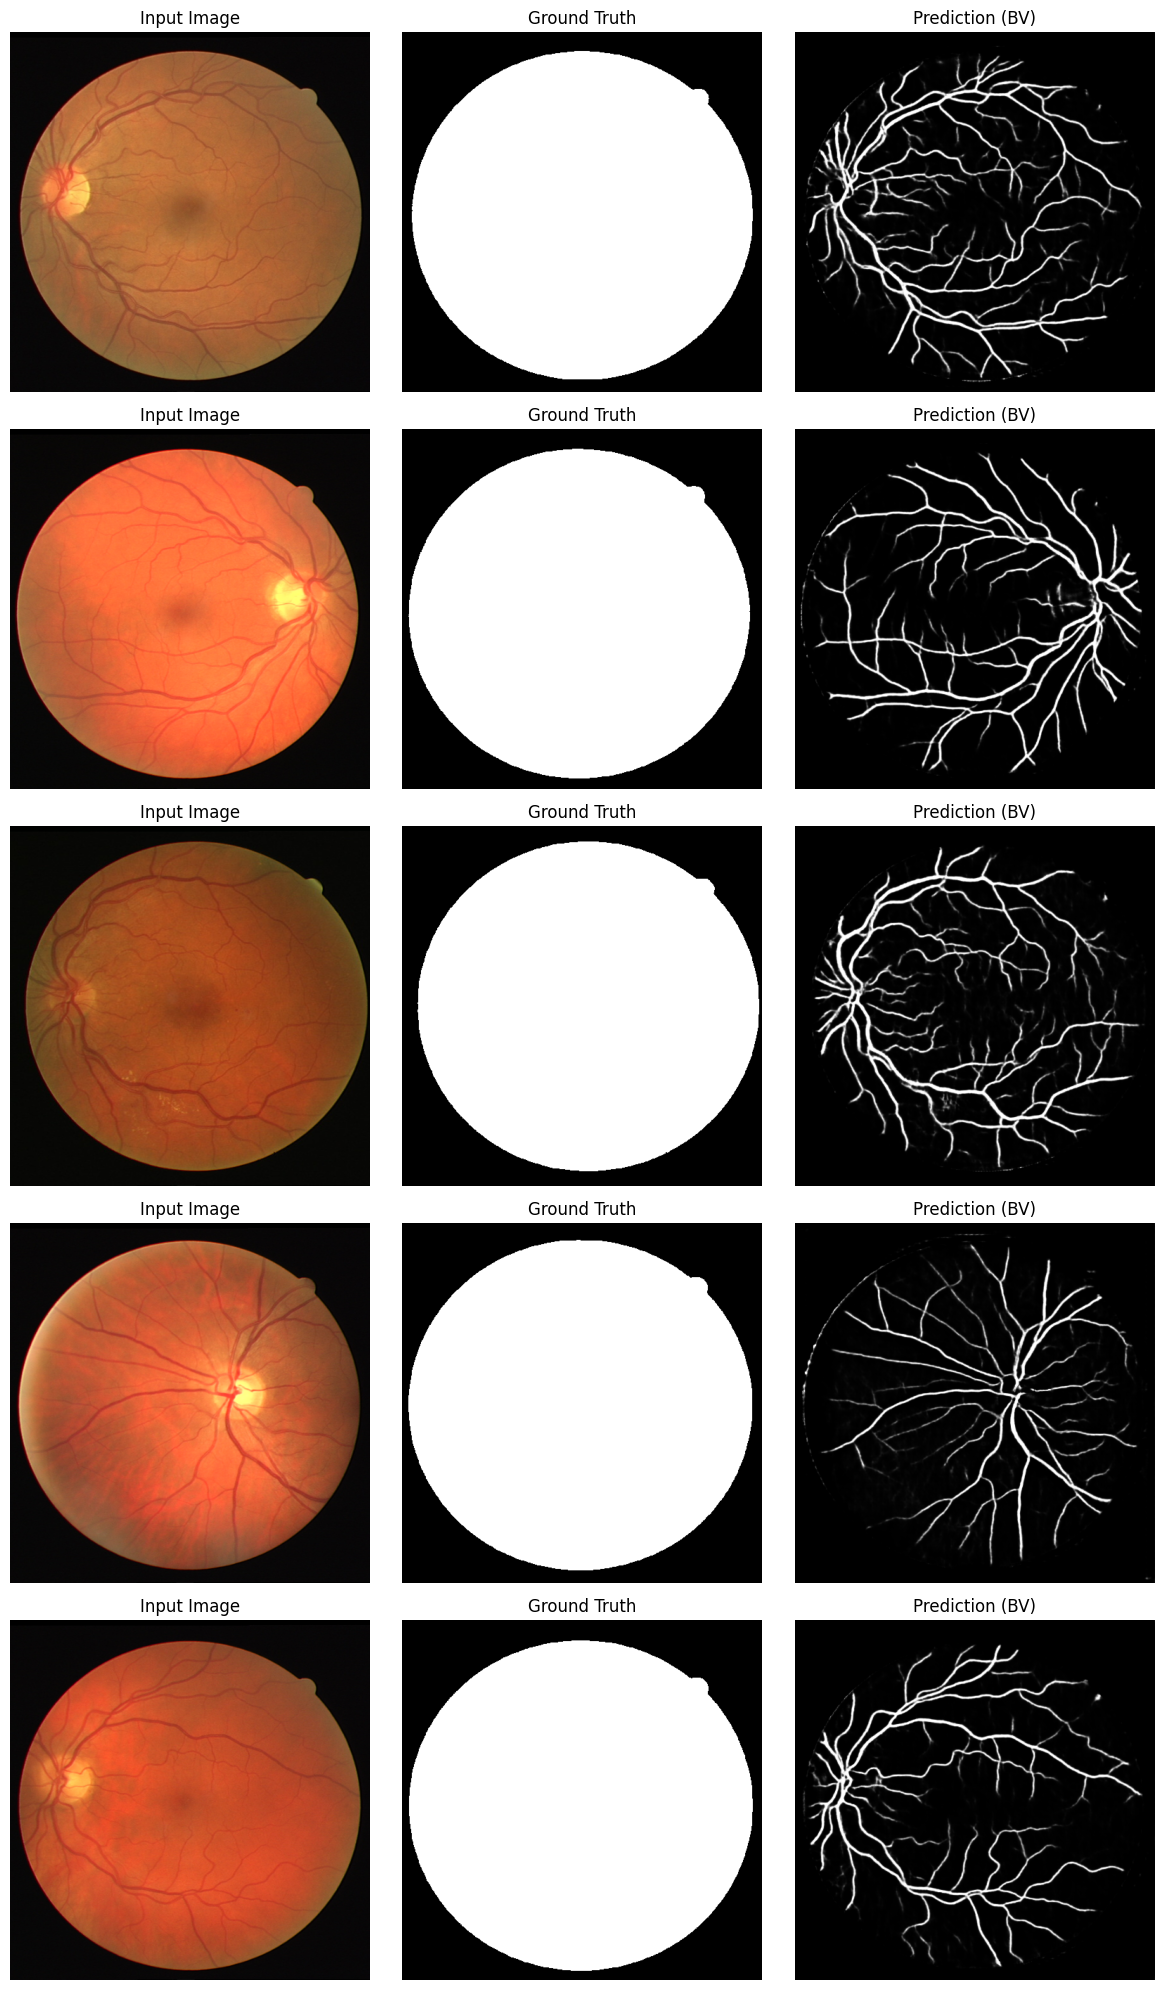


=== Evaluation Complete ===


In [14]:

if __name__ == "__main__":
    # Paths
    weights_path = '/kaggle/input/pretrained/keras/default/1/Model_weights_IOSTAR.h5'
    test_data_path = '/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test'
    
    # Create model
    input_shape = (512, 512, 3)
    print("Creating model...")
    model = create_transfuse_net(input_shape)
    
    # Compile model with custom metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss={'final_output1': bcc_Jaccard_coef_loss, 'final_output2': bcc_Jaccard_coef_loss},
        metrics={'final_output1': [dice_coef, iou, sensitivity, specificity],
                 'final_output2': [dice_coef, iou, sensitivity, specificity]}
    )
    
    # Load weights
    print(f"\nLoading weights from: {weights_path}")
    model.load_weights(weights_path)
    print("Weights loaded successfully!")
    
    # Load test data
    print(f"\nLoading test data from: {test_data_path}")
    X_test, y_test = get_data(test_data_path)
    
    # Convert ground truth to binary
    y_test_binary = (y_test > 0.5).astype(np.uint8)
    
    # Make predictions
    print("\nRunning inference...")
    start_time = time.time()
    predictions = model.predict(X_test, verbose=1)
    end_time = time.time()
    
    inference_time = end_time - start_time
    print(f"Total Inference Time: {inference_time:.2f} seconds")
    print(f"Inference Time per image: {inference_time/len(X_test):.4f} seconds")
    
    # Evaluate metrics for BV (Blood Vessel) task
    print("\n=== Blood Vessel Segmentation Metrics ===")
    eval_BV = evaluate_metrics(y_test_binary, predictions[0])
    
    # Visualize some predictions
    num_samples = min(5, len(X_test))
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        if num_samples == 1:
            ax = axes
        else:
            ax = axes[i]
        
        ax[0].imshow(X_test[i])
        ax[0].set_title('Input Image')
        ax[0].axis('off')
        
        ax[1].imshow(np.squeeze(y_test_binary[i]), cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')
        
        ax[2].imshow(np.squeeze(predictions[0][i]), cmap='gray')
        ax[2].set_title('Prediction (BV)')
        ax[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    print("\nPredictions saved as 'predictions.png'")
    plt.show()
    
    print("\n=== Evaluation Complete ===")